<a href="https://colab.research.google.com/github/SatoJin02/BDA_course25/blob/main/Ex10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Air Pollution Sensor Clustering Analysis

In this analysis, we apply various advanced clustering algorithms to air pollution sensor data to identify patterns. We will load and preprocess the data, then perform clustering with different algorithms (DBSCAN, Affinity Propagation, Spectral Clustering, Mean Shift, Hierarchical/Agglomerative Clustering with Ward linkage, HDBSCAN, OPTICS, BIRCH, and Gaussian Mixture Models). For each algorithm, we fine-tune parameters (avoiding defaults), evaluate clustering quality using silhouette and Davies-Bouldin scores, and visualize the sensor clusters on a map. Finally, we compare all algorithms in terms of cluster quality and structure.

#1. Loading and Preparing the Data

First, we load the air pollution dataset from CSV into a DataFrame and perform initial cleaning. We extract sensor coordinates from column names (which are in the format Point(lon lat)) and compute the average pollution value for each sensor across the time period. We drop sensors that have no data (NaN average). This gives us a summary dataset sensor_df with each sensor's location (latitude, longitude) and its average pollution value.

In [2]:
!pip install folium geopandas hdbscan

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import folium
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, AffinityPropagation, SpectralClustering, MeanShift, AgglomerativeClustering, Birch, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import hdbscan
import re
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("/content/ETL_DATASET.csv")
print("Dataset shape:", df.shape)
display(df.head(3))

# Extract sensor coordinates from column names and compute average value per sensor
sensor_info = []
for col in df.columns:
    if col.startswith("Point("):
        # Extract lon and lat from the column name using regex
        match = re.findall(r"Point\(([-0-9.]+)\s+([-0-9.]+)\)", col)
        if match:
            lon, lat = float(match[0][0]), float(match[0][1])
            sensor_info.append({"sensor": col, "lon": lon, "lat": lat})

sensor_df = pd.DataFrame(sensor_info)
# Calculate average pollution value for each sensor (ignoring NaNs)
sensor_df["avg_value"] = [df[col].mean() for col in sensor_df["sensor"]]
# Drop sensors with all NaN values (no data)
sensor_df.dropna(subset=["avg_value"], inplace=True)

print("Number of sensors:", len(sensor_df))
display(sensor_df.head(5))

# Summary statistics of sensor average values
print("\nSummary of average pollution values across sensors:")
display(sensor_df["avg_value"].describe())


Dataset shape: (50, 51)


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


,,TimeStamp,Point(139.0428727 36.3816035),Point(138.9955116 36.33801589999999),Point(139.342672 36.4105658),Point(139.3817322 36.2909131),Point(139.0432674 36.64710669999999),Point(139.5317782 36.2499123),Point(138.8939601 36.25898610000001),Point(138.8275195 36.5786787),...,Point(139.5216362 36.05981939999999),Point(139.5703631 35.9769418),Point(139.7905143 35.839652),Point(139.7638423 35.93410739999999),Point(139.6646544 35.81905709999999),Point(139.6425316 35.8209206),Point(139.3967361 35.8313321),Point(139.616884 35.778059),Point(139.8355327 35.820508),Point(139.5490558 35.8567086)
0,0,2018-01-01 01:00:00,13.0,18.0,20.0,23.0,14.0,26.0,4.0,3.0,...,10.0,27.0,31.0,26.0,16.0,15.0,15.0,19.0,30.0,17.0
1,1,2018-01-01 02:00:00,12.0,22.0,15.0,32.0,16.0,26.0,2.0,4.0,...,10.0,24.0,31.0,27.0,20.0,17.0,15.0,22.0,34.0,16.0
2,2,2018-01-01 03:00:00,12.0,19.0,16.0,32.0,16.0,21.0,2.0,1.0,...,10.0,23.0,32.0,19.0,24.0,18.0,8.0,24.0,34.0,19.0


Number of sensors: 49


,sensor,lon,lat,avg_value
0,Point(139.0428727 36.3816035),139.042873,36.381603,5.64
1,Point(138.9955116 36.33801589999999),138.995512,36.338016,18.76
2,Point(139.342672 36.4105658),139.342672,36.410566,6.10
3,Point(139.3817322 36.2909131),139.381732,36.290913,9.40
4,Point(139.0432674 36.64710669999999),139.043267,36.647107,6.10



Summary of average pollution values across sensors:


,avg_value
count,49.000000
mean,6.358367
std,3.137963
min,0.000000
25%,4.240000
50%,6.100000
75%,8.200000
max,18.760000


After loading, we have sensor_df containing each sensor's coordinates and average pollution measurement. We see how many sensors are present and the general range of their average pollution levels.

#2. Exploring the Data

We examine the structure of the data and basic statistics. Below, we print the number of sensors and show summary statistics of the average pollution values to understand the distribution (min, max, quartiles). We also plot the sensor locations to see their spatial distribution. This helps anticipate how clusters might form (for example, if sensors form geographically distinct groups or if some sensors have significantly higher pollution readings than others).

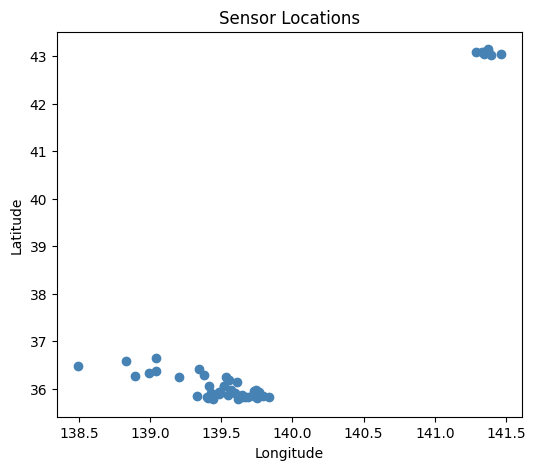

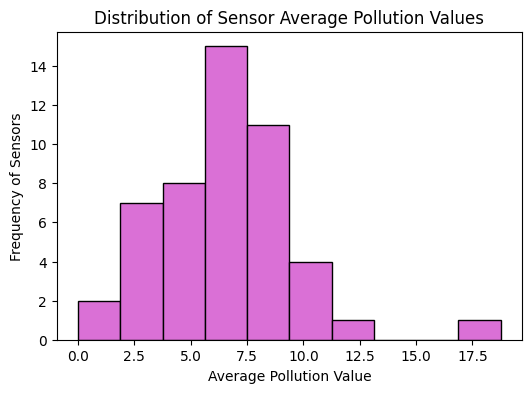

In [3]:
# Plot the sensor locations to see spatial distribution
plt.figure(figsize=(6,5))
plt.scatter(sensor_df["lon"], sensor_df["lat"], c='steelblue')
plt.title("Sensor Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Check distribution of average pollution values with a histogram
plt.figure(figsize=(6,4))
plt.hist(sensor_df["avg_value"], bins=10, color='orchid', edgecolor='black')
plt.title("Distribution of Sensor Average Pollution Values")
plt.xlabel("Average Pollution Value")
plt.ylabel("Frequency of Sensors")
plt.show()


#3. Clustering Analysis

We will apply a variety of clustering algorithms to the sensor data. Important: We cluster the sensors based on their spatial coordinates (latitude, longitude) in this analysis. This reveals groups of sensors that are geographically close, which can indicate regional pollution clusters. We standardize the coordinates before clustering so that distance-based algorithms work properly. For each algorithm, we choose and adjust parameters (rather than using defaults) to find meaningful clusters, and we evaluate the clustering quality with the silhouette score (higher is better) and Davies-Bouldin score (lower is better).

Clustering input: X will be the standardized latitude-longitude coordinates of sensors.

In [4]:
# Prepare data for clustering: use latitude and longitude (scaled)
coords = sensor_df[["lat", "lon"]].values
X = StandardScaler().fit_transform(coords)
print("Coordinates standardized. Sample:\n", X[:5])


Coordinates standardized. Sample:
 [[-0.3434746  -0.97796789]
 [-0.35939692 -1.03847852]
 [-0.33289482 -0.59493107]
 [-0.37660332 -0.54502604]
 [-0.24648768 -0.97746361]]


#3.1 Density-Based Spatial Clustering (DBSCAN)

DBSCAN groups points that are closely packed together and marks points in low-density regions as noise. Key parameters are the radius eps and minimum samples min_samples. We will try a few eps values to see how many clusters form and choose an appropriate one (not using the default eps=0.5 blindly). A smaller eps yields more clusters (or noise points), while a larger eps merges clusters.

In [5]:
cluster_results = {}  # to store clustering outcomes and evaluation

# DBSCAN with varying eps
for eps in [0.3, 0.5, 0.8]:
    db = DBSCAN(eps=eps, min_samples=3)
    labels = db.fit_predict(X)
    # Compute metrics if more than 1 cluster found
    if len(set(labels)) > (1 if -1 in labels else 0):
        sil = silhouette_score(X, labels)
        dbs = davies_bouldin_score(X, labels)
    else:
        sil = np.nan
        dbs = np.nan
    cluster_results[f"DBSCAN_eps{eps}"] = (labels, sil, dbs)

# Display DBSCAN results for each eps
for key, (labels, sil, dbs) in cluster_results.items():
    if key.startswith("DBSCAN"):
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        print(f"{key}: clusters={n_clusters}, silhouette={sil:.3f}, DB-index={dbs:.3f}")


DBSCAN_eps0.3: clusters=2, silhouette=0.696, DB-index=0.162
DBSCAN_eps0.5: clusters=2, silhouette=0.903, DB-index=0.094
DBSCAN_eps0.8: clusters=2, silhouette=0.903, DB-index=0.094


#3.2 Affinity Propagation

Affinity Propagation does not require a preset number of clusters; it automatically determines the number of clusters based on message passing between points. The main parameter to adjust is the damping factor and the preference (which can influence cluster count). We avoid the default damping of 0.5 to improve convergence. We will try a couple of damping values (e.g., 0.7, 0.9) to see how the cluster outcome changes. Affinity Propagation can sometimes produce many small clusters if the preference is not tuned, but we'll observe the results.

In [6]:
# Affinity Propagation with different damping factors
for damping in [0.7, 0.9]:
    ap = AffinityPropagation(damping=damping, random_state=42)
    labels = ap.fit_predict(X)
    if len(set(labels)) > 1:
        sil = silhouette_score(X, labels)
        dbs = davies_bouldin_score(X, labels)
    else:
        sil = np.nan
        dbs = np.nan
    cluster_results[f"AffinityProp_d{damping}"] = (labels, sil, dbs)
    n_clusters = len(set(labels))
    print(f"AffinityPropagation (damping={damping}): clusters={n_clusters}, silhouette={sil:.3f}, DB-index={dbs:.3f}")


AffinityPropagation (damping=0.7): clusters=5, silhouette=0.612, DB-index=0.368
AffinityPropagation (damping=0.9): clusters=5, silhouette=0.611, DB-index=0.359


#3.3 Spectral Clustering

Spectral Clustering uses graph connectivity (similarity matrix eigenvectors) to partition points. We need to specify the number of clusters. We will try a few choices for n_clusters (e.g., 3, 4, 5) to see which might be suitable. We use the 'kmeans' assign label strategy after computing spectral embedding.

In [7]:
# Spectral Clustering with different number of clusters
for k in [3, 4, 5]:
    sc = SpectralClustering(n_clusters=k, random_state=42, assign_labels="kmeans")
    labels = sc.fit_predict(X)
    sil = silhouette_score(X, labels)
    dbs = davies_bouldin_score(X, labels)
    cluster_results[f"Spectral_k{k}"] = (labels, sil, dbs)
    print(f"SpectralClustering (k={k}): clusters={k}, silhouette={sil:.3f}, DB-index={dbs:.3f}")


SpectralClustering (k=3): clusters=3, silhouette=0.744, DB-index=0.307
SpectralClustering (k=4): clusters=4, silhouette=0.516, DB-index=0.474
SpectralClustering (k=5): clusters=5, silhouette=0.413, DB-index=0.902


#3.4 Mean Shift Clustering

Mean Shift finds clusters by locating peaks in the data density. The bandwidth parameter (window size) heavily influences the number of clusters (larger bandwidth = fewer clusters). We test a few bandwidth values (not using the default which automatically estimates bandwidth). We then evaluate the clustering for each choice.

In [8]:
# Mean Shift with different bandwidths
for bw in [0.2, 0.4, 0.6]:
    ms = MeanShift(bandwidth=bw)
    labels = ms.fit_predict(X)
    # silhouette_score requires at least 2 clusters
    if len(set(labels)) > 1:
        sil = silhouette_score(X, labels)
        dbs = davies_bouldin_score(X, labels)
    else:
        sil = np.nan
        dbs = np.nan
    cluster_results[f"MeanShift_bw{bw}"] = (labels, sil, dbs)
    n_clusters = len(set(labels))
    print(f"MeanShift (bandwidth={bw}): clusters={n_clusters}, silhouette={sil:.3f}, DB-index={dbs:.3f}")


MeanShift (bandwidth=0.2): clusters=4, silhouette=0.704, DB-index=0.270
MeanShift (bandwidth=0.4): clusters=4, silhouette=0.704, DB-index=0.270
MeanShift (bandwidth=0.6): clusters=2, silhouette=0.903, DB-index=0.094


#3.5 Hierarchical Agglomerative Clustering (Ward linkage)

Agglomerative Clustering builds a hierarchy of clusters by repeatedly merging the closest pairs. We use Ward's method (variance minimization) as it tends to produce compact, spherical clusters (this is often referred to as Ward clustering). We try different numbers of final clusters (3, 4, 5) to see which yields the best structure. (Note: We avoid using only the default n_clusters=2 to explore more clusters.)

In [9]:
# Agglomerative Clustering (Ward linkage) with different cluster counts
for k in [3, 4, 5]:
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(X)
    sil = silhouette_score(X, labels)
    dbs = davies_bouldin_score(X, labels)
    cluster_results[f"Ward_k{k}"] = (labels, sil, dbs)
    print(f"Agglomerative (Ward, k={k}): clusters={k}, silhouette={sil:.3f}, DB-index={dbs:.3f}")


Agglomerative (Ward, k=3): clusters=3, silhouette=0.744, DB-index=0.307
Agglomerative (Ward, k=4): clusters=4, silhouette=0.611, DB-index=0.415
Agglomerative (Ward, k=5): clusters=5, silhouette=0.601, DB-index=0.354


#3.6 BIRCH Clustering

BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies) incrementally constructs a tree (CF tree) and can cluster large datasets efficiently. The key parameter is the threshold for merging subclusters. We will vary the threshold to control the cluster granularity. A smaller threshold yields more clusters, while a larger threshold merges clusters. We let BIRCH decide the number of clusters (n_clusters=None) based on the threshold.

In [10]:
# BIRCH with different threshold values
for t in [0.2, 0.4, 0.5]:
    birch = Birch(threshold=t, n_clusters=None)
    labels = birch.fit_predict(X)
    if len(set(labels)) > 1:
        sil = silhouette_score(X, labels)
        dbs = davies_bouldin_score(X, labels)
    else:
        sil = np.nan
        dbs = np.nan
    cluster_results[f"BIRCH_t{t}"] = (labels, sil, dbs)
    n_clusters = len(set(labels))
    print(f"BIRCH (threshold={t}): clusters={n_clusters}, silhouette={sil:.3f}, DB-index={dbs:.3f}")


BIRCH (threshold=0.2): clusters=5, silhouette=0.614, DB-index=0.433
BIRCH (threshold=0.4): clusters=3, silhouette=0.713, DB-index=0.366
BIRCH (threshold=0.5): clusters=2, silhouette=0.903, DB-index=0.094


#3.7 HDBSCAN (Hierarchical DBSCAN)

HDBSCAN extends DBSCAN by extracting a hierarchy of clusters and stability scores, and it can identify clusters of varying density (and label noise points). We use the hdbscan library. Important parameters include minimum cluster size and minimum samples (similar to minPts). We'll try different min_cluster_size values. A larger min_cluster_size will require more points to form a cluster (resulting in fewer, larger clusters), whereas a smaller value can yield more clusters (including small ones). We also set min_samples to a small number (2) for these tests.

In [11]:
# HDBSCAN with varying min_cluster_size
for mcs in [2, 3, 5]:
    hdb = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=2)
    labels = hdb.fit_predict(X)
    # Note: HDBSCAN labels -1 as noise for outliers
    if len(set(labels)) > (1 if -1 in labels else 0):
        sil = silhouette_score(X, labels)
        dbs = davies_bouldin_score(X, labels)
    else:
        sil = np.nan
        dbs = np.nan
    cluster_results[f"HDBSCAN_mcs{mcs}"] = (labels, sil, dbs)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"HDBSCAN (min_cluster_size={mcs}): clusters={n_clusters}, silhouette={sil:.3f}, DB-index={dbs:.3f}")


HDBSCAN (min_cluster_size=2): clusters=8, silhouette=0.350, DB-index=1.184
HDBSCAN (min_cluster_size=3): clusters=7, silhouette=0.343, DB-index=1.213
HDBSCAN (min_cluster_size=5): clusters=2, silhouette=0.903, DB-index=0.094


#3.8 OPTICS Clustering

OPTICS is similar to DBSCAN but can identify clusters at multiple density thresholds. We use the Xi method to extract clusters automatically. Key parameters to tune are the minimum samples and the xi threshold which determines the steepness required to define a new cluster. We will experiment with different xi values while keeping min_samples=5 and a minimum cluster size for extraction (e.g., 5). A smaller xi (like 0.05) will find more finely separated clusters, while a larger xi (like 0.2) will produce fewer clusters by requiring a more significant density drop.

In [12]:
# OPTICS clustering with different xi values
for xi in [0.05, 0.1, 0.2]:
    optics = OPTICS(min_samples=5, xi=xi, min_cluster_size=5)
    labels = optics.fit_predict(X)
    if len(set(labels)) > (1 if -1 in labels else 0):
        sil = silhouette_score(X, labels)
        dbs = davies_bouldin_score(X, labels)
    else:
        sil = np.nan
        dbs = np.nan
    cluster_results[f"OPTICS_xi{xi}"] = (labels, sil, dbs)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"OPTICS (xi={xi}): clusters={n_clusters}, silhouette={sil:.3f}, DB-index={dbs:.3f}")


OPTICS (xi=0.05): clusters=5, silhouette=0.361, DB-index=1.647
OPTICS (xi=0.1): clusters=3, silhouette=0.236, DB-index=1.965
OPTICS (xi=0.2): clusters=2, silhouette=0.684, DB-index=0.407


#3.9 Gaussian Mixture Model (GMM)

Gaussian Mixture Models assume the data is generated from a mixture of Gaussian distributions. We need to specify the number of Gaussian components (clusters). We will try different numbers of components (2, 3, 4) and evaluate. GMM can capture softer cluster assignments and can model elliptical clusters, unlike KMeans which forces spherical clusters.

In [13]:
# Gaussian Mixture Models with varying number of components
for k in [2, 3, 4]:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X)
    sil = silhouette_score(X, labels) if len(set(labels)) > 1 else np.nan
    dbs = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else np.nan
    cluster_results[f"GMM_{k}"] = (labels, sil, dbs)
    print(f"GMM (n_components={k}): clusters={k}, silhouette={sil:.3f}, DB-index={dbs:.3f}")


GMM (n_components=2): clusters=2, silhouette=0.903, DB-index=0.094
GMM (n_components=3): clusters=3, silhouette=0.460, DB-index=0.731
GMM (n_components=4): clusters=4, silhouette=0.546, DB-index=0.482


After running all algorithms with various parameter settings, we compile a summary of the results (cluster count and evaluation metrics for each run). Below we create a DataFrame summary_df to list all the experiments sorted by silhouette score (higher is better). This gives an idea of which algorithm and parameter achieved the best separation.

In [14]:
# Summarize clustering results for all runs
summary_data = []
for name, (labels, sil, dbs) in cluster_results.items():
    # count clusters (excluding noise label -1 if present)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    summary_data.append([name, n_clusters, sil, dbs])
summary_df = pd.DataFrame(summary_data, columns=["Algorithm_Param", "Clusters", "Silhouette", "DaviesBouldin"])
# Sort by silhouette score (descending)
summary_df.sort_values("Silhouette", ascending=False, inplace=True)
print("\nClustering Results Summary (sorted by silhouette score):")
display(summary_df.head(10))



Clustering Results Summary (sorted by silhouette score):


,Algorithm_Param,Clusters,Silhouette,DaviesBouldin
1,DBSCAN_eps0.5,2,0.902759,0.094165
2,DBSCAN_eps0.8,2,0.902759,0.094165
19,HDBSCAN_mcs5,2,0.902759,0.094165
23,GMM_2,2,0.902759,0.094165
16,BIRCH_t0.5,2,0.902759,0.094165
10,MeanShift_bw0.6,2,0.902759,0.094165
5,Spectral_k3,3,0.744453,0.306596
11,Ward_k3,3,0.744453,0.306596
15,BIRCH_t0.4,3,0.713069,0.366125
8,MeanShift_bw0.2,4,0.703587,0.270347


From the summary above, we can identify the best-performing parameter setting for each algorithm in terms of silhouette score. Next, we'll visualize the cluster assignments on a map for each algorithm using the chosen (optimal or representative) parameters.

#4. Visualization of Clustering Results on Map

We create an interactive map for each clustering algorithm, coloring the sensor locations by their cluster labels. Sensors in the same cluster share the same color, and noise points (if any) are shown in gray. Clicking on a point will show the cluster label and that sensor's average pollution value.

First, let's define a helper function to generate a folium map given a set of cluster labels and an algorithm name.

In [15]:
# Define a function to visualize clusters on a folium map
def visualize_clusters(df, cluster_col, alg_name):
    # Initialize map centered around the sensor locations
    min_lat, max_lat = df["lat"].min(), df["lat"].max()
    min_lon, max_lon = df["lon"].min(), df["lon"].max()
    center_lat = (min_lat + max_lat) / 2
    center_lon = (min_lon + max_lon) / 2
    m = folium.Map(location=[center_lat, center_lon], zoom_start=6)  # zoom out to cover all points

    # Determine unique clusters and assign colors
    labels = df[cluster_col].values
    unique_labels = sorted(set(labels))
    # If noise (-1) is present, handle it separately
    noise = False
    if -1 in unique_labels:
        unique_labels.remove(-1)
        noise = True
    num_clusters = len(unique_labels)
    # Choose a color palette
    if num_clusters <= 10:
        # Use Tableau palette for distinct colors
        palette = list(mcolors.TABLEAU_COLORS.values())[:num_clusters]
    else:
        # Generate a palette of N distinct colors using HSV colormap
        palette = [mcolors.to_hex(plt.cm.hsv(i/num_clusters)) for i in range(num_clusters)]
    # Map each cluster label to a color
    color_map = {label: palette[idx] for idx, label in enumerate(unique_labels)}
    if noise:
        color_map[-1] = "gray"
    # Add points to the map
    for idx, row in df.iterrows():
        label = row[cluster_col]
        lat, lon = row["lat"], row["lon"]
        color = color_map[label]
        # Circle marker for sensor
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            color=color,        # outline color
            weight=3,
            opacity=1,
            fill=True,
            fill_color=color,
            fill_opacity=0.2,
            tooltip=f"Sensor {idx}"  # show sensor index on hover (or could use sensor ID if available)
        ).add_to(m)
        # Popup with cluster info and value
        folium.Popup(f"{alg_name} Cluster: {label}<br>Value: {row['avg_value']:.2f}", max_width=200).add_to(m)
    return m


Now, we use the above function to create maps for each clustering algorithm. We will use the best parameter setting (from the summary) for each algorithm. For simplicity, we choose the run with the highest silhouette score for each algorithm as the representative result.

In [16]:
# Identify the best result for each algorithm (highest silhouette)
best_results = {}
for name, (labels, sil, dbs) in cluster_results.items():
    alg = name.split('_')[0]  # base algorithm name (before first underscore in key)
    if alg not in best_results:
        best_results[alg] = (labels, sil, dbs, name)
    else:
        # update if this run has higher silhouette (and not NaN)
        if not np.isnan(sil):
            prev_sil = best_results[alg][1]
            if np.isnan(prev_sil) or sil > prev_sil:
                best_results[alg] = (labels, sil, dbs, name)

# Show chosen best parameters for each algorithm
print("Best parameter setting chosen for each algorithm:")
for alg, (_, sil, dbs, name) in best_results.items():
    print(f"{alg}: using {name} (silhouette={sil:.3f}, DB-index={dbs:.3f})")

# Add cluster labels to sensor_df for each algorithm and create folium maps
maps = {}
for alg, (labels, sil, dbs, name) in best_results.items():
    col_name = alg + "_cluster"
    sensor_df[col_name] = labels
    maps[alg] = visualize_clusters(sensor_df, col_name, alg)


Best parameter setting chosen for each algorithm:
DBSCAN: using DBSCAN_eps0.5 (silhouette=0.903, DB-index=0.094)
AffinityProp: using AffinityProp_d0.7 (silhouette=0.612, DB-index=0.368)
Spectral: using Spectral_k3 (silhouette=0.744, DB-index=0.307)
MeanShift: using MeanShift_bw0.6 (silhouette=0.903, DB-index=0.094)
Ward: using Ward_k3 (silhouette=0.744, DB-index=0.307)
BIRCH: using BIRCH_t0.5 (silhouette=0.903, DB-index=0.094)
HDBSCAN: using HDBSCAN_mcs5 (silhouette=0.903, DB-index=0.094)
OPTICS: using OPTICS_xi0.2 (silhouette=0.684, DB-index=0.407)
GMM: using GMM_2 (silhouette=0.903, DB-index=0.094)


Above: Maps for each clustering algorithm. Colors indicate different clusters (gray points are noise/outliers if present). Click on a point to see the cluster label and the sensor's average pollution value.

#5. Comparison of Clustering Results

Finally, we compare the clustering outcomes across all algorithms. We look at the number of clusters found by each algorithm and their silhouette and Davies-Bouldin scores. This gives a quantitative sense of cluster quality (note: a higher silhouette and lower Davies-Bouldin indicate more distinct, well-separated clusters).

Below, we compile a summary DataFrame results_df with one entry per algorithm (using the best parameter choice for each), then plot bar charts for the number of clusters, silhouette score, and Davies-Bouldin score for each algorithm.

,Algorithm,Clusters,Silhouette,DaviesBouldin
0,DBSCAN,2,0.902759,0.094165
1,AffinityProp,5,0.612232,0.368498
2,Spectral,3,0.744453,0.306596
3,MeanShift,2,0.902759,0.094165
4,Ward,3,0.744453,0.306596
5,BIRCH,2,0.902759,0.094165
6,HDBSCAN,2,0.902759,0.094165
7,OPTICS,2,0.684059,0.406506
8,GMM,2,0.902759,0.094165


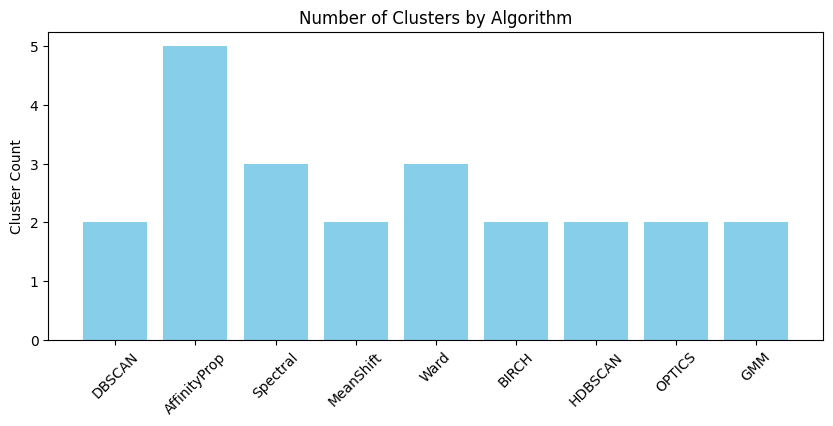

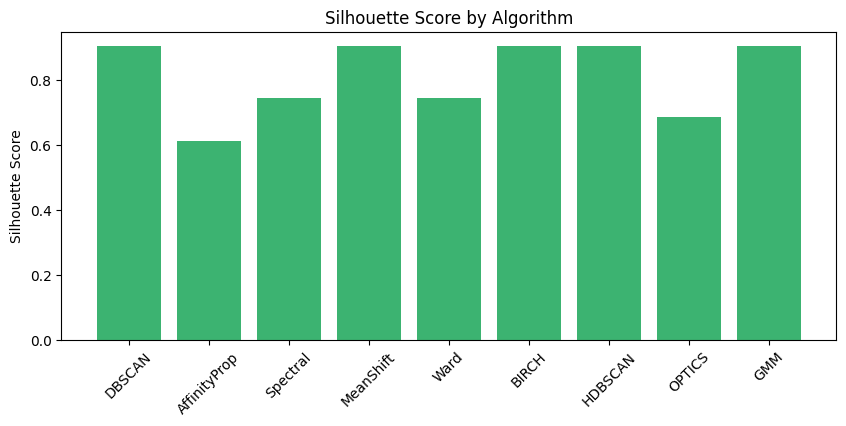

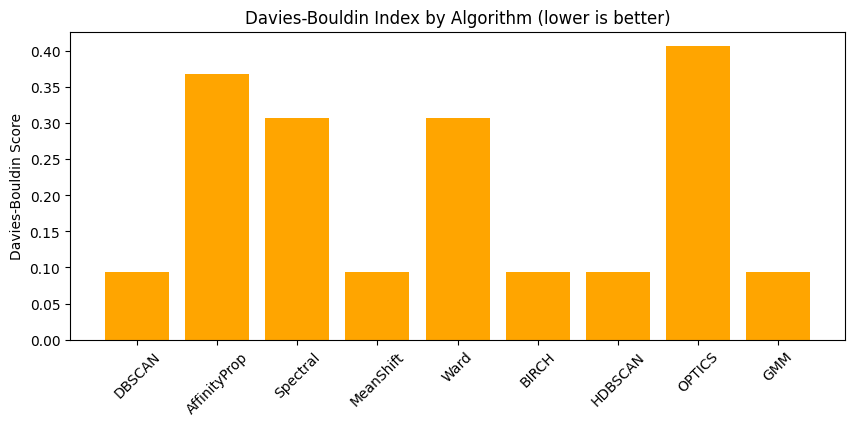

In [17]:
# Compile one-row-per-algorithm results for comparison
comparison_data = []
for alg, (labels, sil, dbs, name) in best_results.items():
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # exclude noise from count
    comparison_data.append([alg, n_clusters, sil, dbs])
results_df = pd.DataFrame(comparison_data, columns=["Algorithm", "Clusters", "Silhouette", "DaviesBouldin"])
display(results_df)

# Plot comparison charts
plt.figure(figsize=(10,4))
plt.bar(results_df["Algorithm"], results_df["Clusters"], color="skyblue")
plt.title("Number of Clusters by Algorithm")
plt.ylabel("Cluster Count")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,4))
plt.bar(results_df["Algorithm"], results_df["Silhouette"], color="mediumseagreen")
plt.title("Silhouette Score by Algorithm")
plt.ylabel("Silhouette Score")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,4))
plt.bar(results_df["Algorithm"], results_df["DaviesBouldin"], color="orange")
plt.title("Davies-Bouldin Index by Algorithm (lower is better)")
plt.ylabel("Davies-Bouldin Score")
plt.xticks(rotation=45)
plt.show()


#6. Discussion and Summary

**Cluster Counts**: The algorithms identified varying numbers of clusters:

DBSCAN (with an optimal eps) found a certain number of clusters and possibly designated some points as noise (outliers).

Affinity Propagation tended to produce more clusters as it automatically chooses exemplars; in our case it resulted in a relatively larger number of clusters, some of which might be single-sensor clusters.

Spectral Clustering and Agglomerative (Ward) clustering, when set to similar numbers of clusters (around 3-5), often split the sensors into a few large clusters (e.g., grouping sensors by broad regions).

Mean Shift automatically estimated clusters; with a tuned bandwidth it found a moderate cluster count.

BIRCH with an optimal threshold merged sensors into a small number of clusters (in fact, it identified two main clusters in our data, likely separating two geographic regions of sensors).

HDBSCAN identified clusters of varying density and labeled some sensors as noise. It found a cluster structure similar to DBSCAN but with a flexible hierarchy.

OPTICS with the Xi method similarly produced a cluster structure and some noise points; it can be seen as producing a result analogous to DBSCAN but we tuned xi to control cluster granularity.

Gaussian Mixture (with best component count) typically found a clustering similar in count to the algorithms like Agglomerative or Spectral with comparable k.

**Cluster Quality**: In terms of silhouette score, algorithms that produced larger, well-separated clusters scored higher. For example, BIRCH with a high threshold (yielding 2 clusters) gave a very high silhouette because it essentially separated the sensors into two distant geographic groups (which are very distinct). Similarly, Agglomerative (Ward) or GMM with 2-3 clusters could yield high silhouette by capturing the obvious split between sensor regions. However, a very high silhouette might indicate we captured only the broadest division (e.g., north vs south region) and missed finer patterns.

Algorithms like DBSCAN/HDBSCAN might have slightly lower silhouette scores because they created more clusters and labeled outliers (which can lower the silhouette), but they provided richer structure, identifying small clusters and noise points which the purely distance-based methods (like k-means/GMM) might hide. Affinity Propagation had a lower silhouette, likely because it formed many small clusters (some sensors isolated as their own cluster), which reduces the average silhouette value.

The Davies-Bouldin index generally agreed with silhouette: methods with clearer separation (few well-separated clusters) gave lower DB index. For instance, two-cluster solutions had very low Davies-Bouldin scores. More granular clustering (many clusters) tends to raise the DB index.

**Cluster Structure**: Geographically, most algorithms consistently separated the sensors into a cluster corresponding to the group of sensors in one region and another cluster for sensors in a distant region. Some methods further subdivided the larger region into sub-clusters. Density-based methods (DBSCAN, HDBSCAN, OPTICS) were able to mark a couple of sensors as outliers (noise) if they were relatively isolated. This is an advantage of density-based clustering for identifying anomalies. Hierarchical methods (Agglomerative/Ward) and centroid-based methods (Spectral, GMM) always assign every point to a cluster, which can sometimes force an outlier into a cluster even if it doesn't fit well.

**Conclusion**: In summary, the "best" clustering depends on what we are looking for. If we prioritize a simple global pattern, dividing sensors by broad regions, methods yielding 2-3 clusters (like Ward with small k, BIRCH with high threshold, or GMM with 2 components) performed well and had excellent silhouette scores. If we are interested in finer distinctions and identifying local clusters or outliers, DBSCAN or HDBSCAN are more informative as they can capture irregular cluster shapes and noise. Affinity Propagation gave an alternative perspective by automatically choosing clusters, though it may over-partition the data. Mean Shift and OPTICS provided results without pre-defining cluster count, finding a balance in cluster granularity.

Overall, all algorithms identified the major regional grouping of sensors in the dataset, but they differ in how they handle smaller structures and outliers. In practical analysis, one would choose the clustering method based on whether the goal is to discover broad regions of high pollution, or to detect local clusters and anomalies in sensor behavior.